In [4]:
from __future__ import print_function
from collections import defaultdict
import pandas as pd
import numpy as np
import matplotlib
import pandas_profiling
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import seaborn as sns

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 8)
pd.options.display.float_format = '{:.2f}'.format

In [5]:
fn = 'orders.csv'
df = pd.read_csv(fn)

In [6]:
df[df['discount']<0].head(5)

,DISCOUNT_VALUE,NAME,PRICE,QUANTITY,date_insert,discount,itemID,orderID,ordered_item_count,price,user_id
83,NaN,История государства Российского,777.00,1,2017-03-19 03:21:08,-1277.00,196964,601703,2,1556.00,195867
84,NaN,100 любимых стихов и 100 любимых сказок для ма...,500.00,1,2017-03-19 03:21:08,-1277.00,191129,601703,2,1556.00,195867
190,NaN,"Кыш, Двапортфеля и целая неделя. Кыш и я в Кры...",437.00,1,2017-03-18 11:15:09,-823.00,198440,601300,2,1102.00,910987
191,NaN,В Стране Вечных Каникул. Саша и Шура (вес: 640...,386.00,1,2017-03-18 11:15:09,-823.00,200733,601300,2,1102.00,910987
376,NaN,Первый учебник малыша. От 6 месяцев до 3 лет,376.00,1,2017-03-17 10:15:09,-564.00,204137,600758,2,843.00,910569


Задача - кластеризовать пользователей по признакам - 
* кол-во заказов, 
* кол-во купленных книг, 
* среднее/min/max кол-во книг в заказе, 
* средняя/min/max стоимость заказа, 
* средняя/min/max стоимость книги в заказе
* средний/min/max размер скидки в процентах (предварительно перевести в флоат, заполнить пустые значения нулями)
* суммарная стоимость

    вычистим датасет от явных нарушений

In [7]:
df[df.duplicated()]
df = df.drop_duplicates()
df['DISCOUNT_VALUE'] = df['DISCOUNT_VALUE'].replace('[\%]','',regex=True).astype(float).fillna(0.0)
df=df.dropna(subset=["NAME"])
df.describe()

,DISCOUNT_VALUE,PRICE,QUANTITY,discount,itemID,orderID,ordered_item_count,price,user_id
count,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00,557801.00
mean,17.72,242.66,1.65,519.42,562130.60,662757.87,12.15,2797.26,641013.09
std,11.26,260.45,5.05,1032.43,557124.10,37746.45,19.61,7586.31,386438.73
min,0.00,0.00,1.00,-1963.00,131823.00,597731.00,1.00,1.00,3.00
25%,7.04,92.00,1.00,175.00,178534.00,630533.00,4.00,1053.00,194841.00
50%,19.92,185.67,1.00,313.00,196485.00,662686.00,7.00,1389.00,911644.00
75%,24.16,313.00,1.00,537.00,727802.00,694208.00,13.00,2276.40,948489.00
max,94.02,19792.18,500.00,23851.00,1787508.00,730392.00,277.00,386495.00,998104.00


In [8]:
"""
формула рассчета изначальной цены за книгу (без скидки)
"""
def book_price(price, discount):
    #price = nominal_price - (nominal_price/100) * discount
    #price = nominal_price * (1 - discount/100)
    nominal_price = price/(1 - discount/100)
    return round(nominal_price)

Добавим столбец с изначальной ценой книги

In [9]:
df['BOOK_PRICE'] = book_price(df['PRICE'], df['DISCOUNT_VALUE'])

Сгруппируем по клиенту, получив тем самым значения его затрат и скидок

In [10]:
df_res = df.groupby('user_id').agg({'DISCOUNT_VALUE': ['min', 'max' , 'mean'],
                           'BOOK_PRICE': ['min', 'max' , 'mean'],
                           'QUANTITY': ['min', 'max' , 'mean', 'sum'],
                           'price' : ['sum', 'count']
                          })
df_res.head(5)

DISCOUNT_VALUE             BOOK_PRICE                QUANTITY      \
                   min   max  mean        min     max   mean      min max   
user_id                                                                     
3                 3.85 45.08 36.36     156.00  558.00 442.58        1   8   
5                 9.77 47.00 29.52      56.00 1649.00 358.42        1   2   
10               30.09 45.16 42.02     231.00 1447.00 496.70        1   1   
11               15.86 45.21 44.39     127.00 2950.00 533.93        1   2   
22                4.05  4.05  4.05     247.00  247.00 247.00        3   3   

                      price        
        mean  sum       sum count  
user_id                            
3       1.37   26  41494.00    19  
5       1.01  134 200159.07   133  
10      1.00   10  10204.00    10  
11      1.02   46  63991.00    45  
22      3.00    3    886.00     1

Приведем названия столбцов к плоской шкале

In [11]:
df_res.columns = ['_'.join(a).lower() for a in df_res.columns.tolist()]
df_res.columns


Index(['discount_value_min', 'discount_value_max', 'discount_value_mean',
       'book_price_min', 'book_price_max', 'book_price_mean', 'quantity_min',
       'quantity_max', 'quantity_mean', 'quantity_sum', 'price_sum',
       'price_count'],
      dtype='object')

Уберем индексирования по user_id и признак его тоже использовать не будем

In [12]:
features = df_res.columns
df_res.reset_index(inplace=True)
df_res.head(5)

,user_id,discount_value_min,discount_value_max,discount_value_mean,book_price_min,book_price_max,book_price_mean,quantity_min,quantity_max,quantity_mean,quantity_sum,price_sum,price_count
0,3,3.85,45.08,36.36,156.00,558.00,442.58,1,8,1.37,26,41494.00,19
1,5,9.77,47.00,29.52,56.00,1649.00,358.42,1,2,1.01,134,200159.07,133
2,10,30.09,45.16,42.02,231.00,1447.00,496.70,1,1,1.00,10,10204.00,10
3,11,15.86,45.21,44.39,127.00,2950.00,533.93,1,2,1.02,46,63991.00,45
4,22,4.05,4.05,4.05,247.00,247.00,247.00,3,3,3.00,3,886.00,1


отмасштабируем и приведем к матричному виду

In [13]:
from sklearn.pipeline import make_union, make_pipeline
from sklearn.preprocessing import MinMaxScaler

scaler = MinMaxScaler()
vec = scaler.fit_transform(df_res[features])
print(vec.shape)
vec[:3]

(76258, 12)


array([[  5.13128082e-02,   4.79472453e-01,   4.84543025e-01,
          7.24267608e-03,   2.33591948e-02,   2.05326365e-02,
          0.00000000e+00,   1.40280561e-02,   9.23361034e-04,
          5.68310980e-03,   1.30623277e-03,   8.09352518e-03],
       [  1.30214581e-01,   4.99893640e-01,   3.93388509e-01,
          2.59993500e-03,   6.91130216e-02,   1.66253429e-02,
          0.00000000e+00,   2.00400802e-03,   1.88441027e-05,
          3.02341441e-02,   6.30137662e-03,   5.93525180e-02],
       [  4.01039584e-01,   4.80323335e-01,   5.60042650e-01,
          1.07247319e-02,   6.06416440e-02,   2.30453758e-02,
          0.00000000e+00,   0.00000000e+00,   0.00000000e+00,
          2.04591953e-03,   3.21151104e-04,   4.04676259e-03]])

проверим дисперсию 

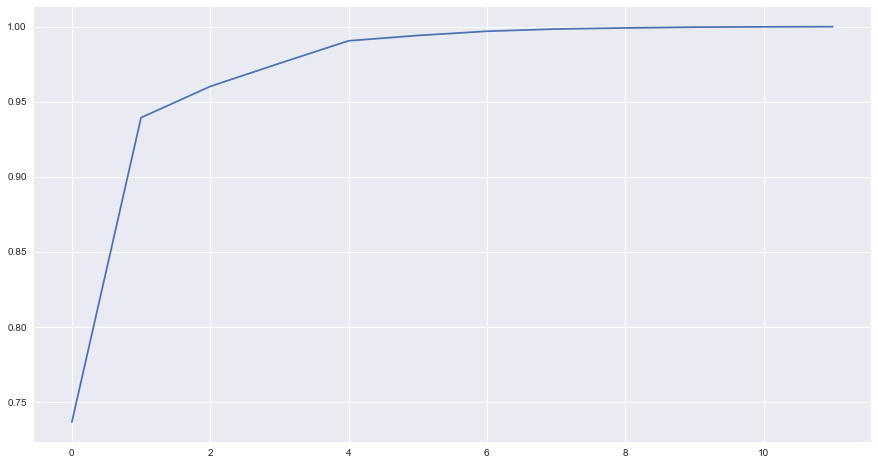

In [14]:
from sklearn.decomposition import PCA
pca = PCA()
pca.fit(vec)
cumsum = np.cumsum(pca.explained_variance_ratio_)
plt.plot(cumsum)

в принципе даже 2 признака покрывают 95% записей, возьмем 3 для большей точности

In [15]:
pca = PCA(n_components=2)
X_reduced = pca.fit_transform(vec)
print(X_reduced.shape)
X_reduced[:3]

(76258, 2)


array([[ 0.27887838,  0.25274575],
       [ 0.27746568,  0.21437175],
       [ 0.51510823,  0.0014289 ]])

In [16]:
from sklearn.cluster import DBSCAN
from sklearn import metrics

X = X_reduced
# Compute DBSCAN
db = DBSCAN(eps=0.03, min_samples=5).fit(X)
core_samples_mask = np.zeros_like(db.labels_, dtype=bool)
core_samples_mask[db.core_sample_indices_] = True
labels = db.labels_

# Number of clusters in labels, ignoring noise if present.
n_clusters_ = len(set(labels)) - (1 if -1 in labels else 0)

print('Estimated number of clusters: %d' % n_clusters_)
#print("Homogeneity: %0.3f" % metrics.homogeneity_score(labels_true, labels))
#print("Completeness: %0.3f" % metrics.completeness_score(labels_true, labels))
#print("V-measure: %0.3f" % metrics.v_measure_score(labels_true, labels))
#print("Adjusted Rand Index: %0.3f"
#      % metrics.adjusted_rand_score(labels_true, labels))
#print("Adjusted Mutual Information: %0.3f"
#      % metrics.adjusted_mutual_info_score(labels_true, labels))
#print("Silhouette Coefficient: %0.3f"
#      % metrics.silhouette_score(X, labels))


Estimated number of clusters: 9


Подбором параметров довели до кол-ва кластеров = 9

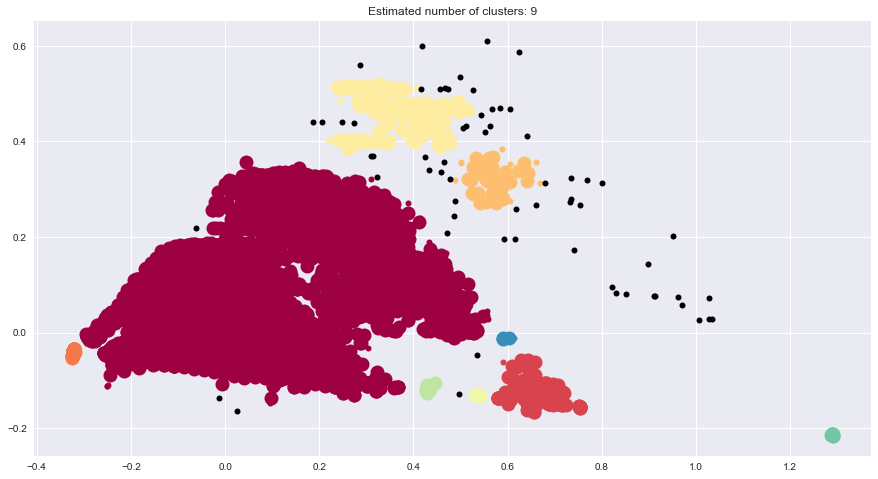

In [17]:
# Plot result
import matplotlib.pyplot as plt

# Black removed and is used for noise instead.
unique_labels = set(labels)
colors = [plt.cm.Spectral(each)
          for each in np.linspace(0, 1, len(unique_labels))]
for k, col in zip(unique_labels, colors):
    if k == -1:
        # Black used for noise.
        col = [0, 0, 0, 1]

    class_member_mask = (labels == k)

    xy = X[class_member_mask & core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=14)

    xy = X[class_member_mask & ~core_samples_mask]
    plt.plot(xy[:, 0], xy[:, 1], 'o', markerfacecolor=tuple(col),
             markeredgecolor='k', markersize=6)

plt.title('Estimated number of clusters: %d' % n_clusters_)
plt.show()

Полученный набор классов добавим в исследуемый сгруппированный датасет

In [18]:
df_res['class'] = db.labels_.reshape(-1,1)

In [19]:
df_res.head(5)

,user_id,discount_value_min,discount_value_max,discount_value_mean,book_price_min,book_price_max,book_price_mean,quantity_min,quantity_max,quantity_mean,quantity_sum,price_sum,price_count,class
0,3,3.85,45.08,36.36,156.00,558.00,442.58,1,8,1.37,26,41494.00,19,0
1,5,9.77,47.00,29.52,56.00,1649.00,358.42,1,2,1.01,134,200159.07,133,0
2,10,30.09,45.16,42.02,231.00,1447.00,496.70,1,1,1.00,10,10204.00,10,0
3,11,15.86,45.21,44.39,127.00,2950.00,533.93,1,2,1.02,46,63991.00,45,0
4,22,4.05,4.05,4.05,247.00,247.00,247.00,3,3,3.00,3,886.00,1,0


Оценим полученные группы по прибыльности и кол-ву человек

In [33]:
df_class = df_res.groupby('class').agg({'price_sum':'sum', 'user_id': 'count', 'discount_value_mean':'mean', 
                                        'book_price_mean':'mean', 'quantity_sum': 'sum' })

df_class.columns = ['price_sum' , 'user_count', 'discount_mean', 'book_price_mean', 'book_count']
df_class.sort_values('price_sum')

,price_sum,user_count,discount_mean,book_price_mean,book_count
class,,,,,
5,11966.40,12,39.94,238.04,55
8,16236.00,5,44.06,633.80,16
7,27216.00,7,74.96,434.02,62
6,324825.43,28,34.99,525.44,337
3,1276917.49,49,36.38,322.89,1007
-1,16891969.25,64,40.83,945.78,5942
2,22224918.16,3398,0.00,506.33,14375
1,22619236.00,1088,44.97,498.49,26196
4,54284793.57,212,25.51,272.04,14298


Можно выделить что есть ряд клиентов которые покупают вообще без скидок

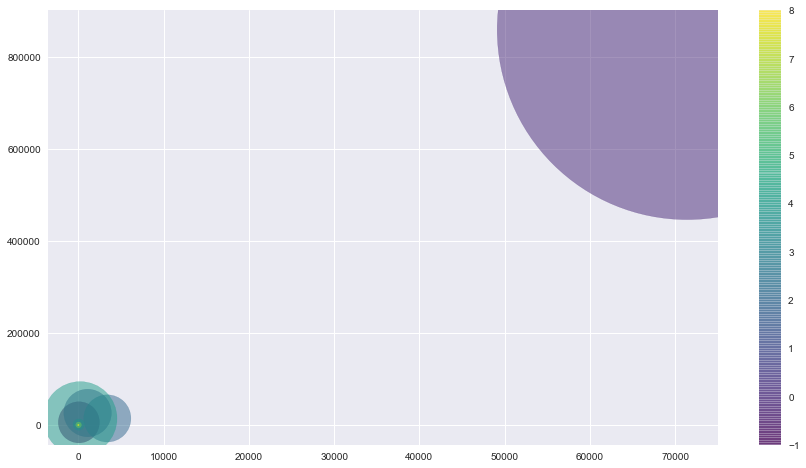

In [36]:
fig, ax = plt.subplots(1, 1)
sc = plt.scatter(df_class['user_count'], df_class['book_count'], 
                 s=df_class['price_sum'] / 10000, 
                 c=df_class.index.values, 
                 alpha=0.5, cmap=plt.cm.get_cmap('viridis') )
plt.colorbar(sc)

соотношение кол-во проданных книг, кол-ва клиентов и затраченной суммы в каждом кластере

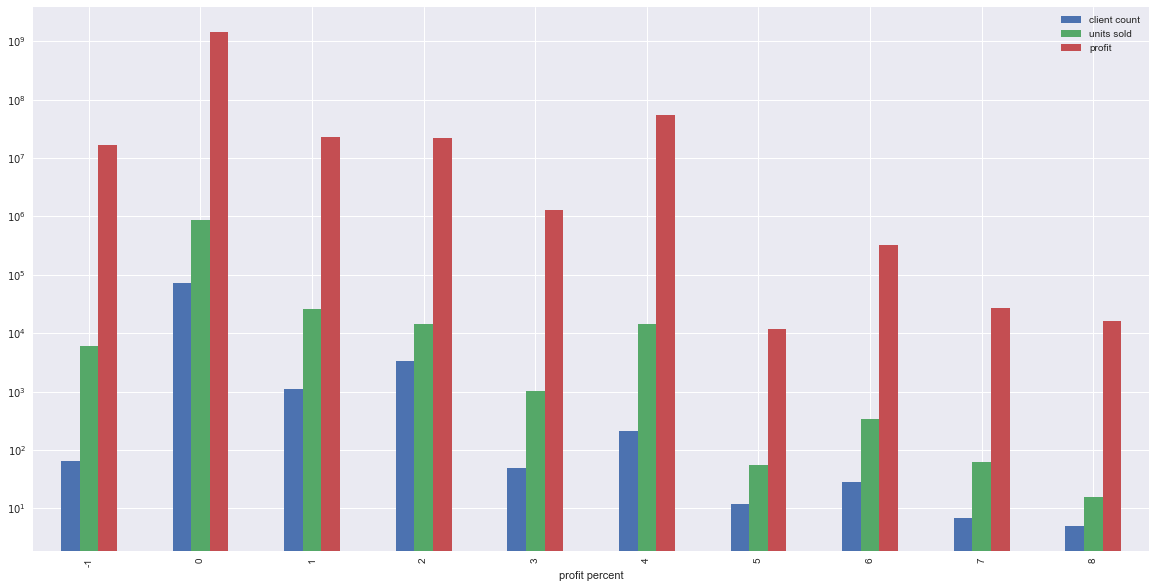

In [43]:
ax = df_class.plot.bar(y=['user_count', 'book_count','price_sum'], figsize=(20,10))
ax.legend(["client count", "units sold", "profit"])
ax.set_xlabel("profit percent")  
plt.yscale('log')

тоже самое но в процентном отношении

In [47]:
sum_cols = df_class.sum()
sum_cols

price_sum         1560313584.55
user_count             76258.00
discount_mean            356.93
book_price_mean         4804.93
book_count            920778.00
dtype: float64

In [51]:
df_proc = df_class.apply(lambda x: x/(x.sum()/100))
df_proc

,price_sum,user_count,discount_mean,book_price_mean,book_count
class,,,,,
-1,1.08,0.08,11.44,19.68,0.65
0,92.46,93.62,4.29,8.91,93.24
1,1.45,1.43,12.60,10.37,2.84
2,1.42,4.46,0.00,10.54,1.56
3,0.08,0.06,10.19,6.72,0.11
4,3.48,0.28,7.15,5.66,1.55
5,0.00,0.02,11.19,4.95,0.01
6,0.02,0.04,9.80,10.94,0.04
7,0.00,0.01,21.00,9.03,0.01


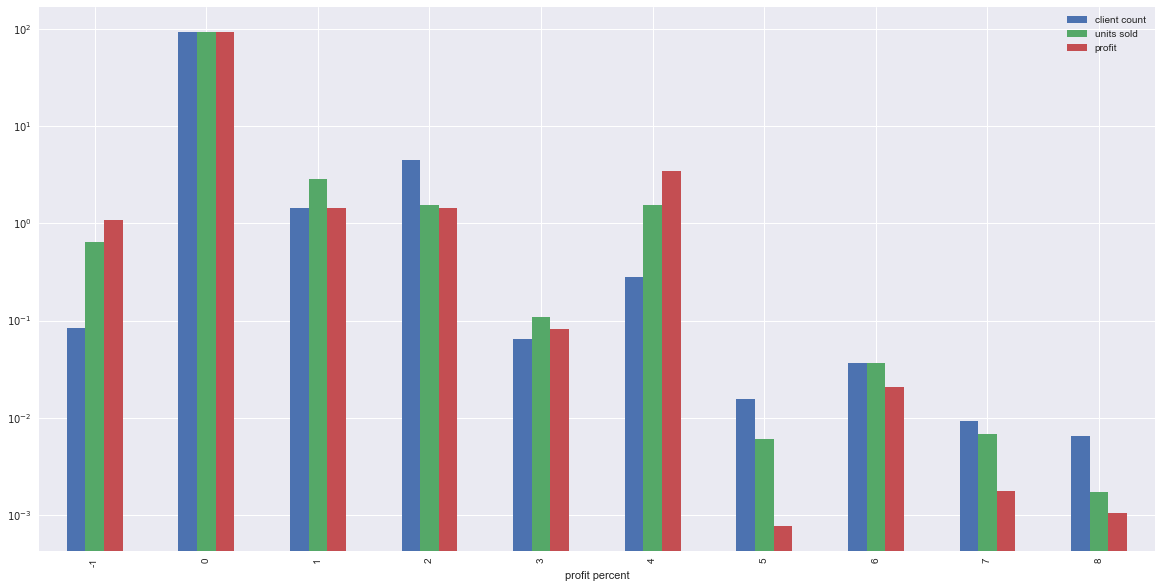

In [55]:
ax = df_proc.plot.bar(y=['user_count', 'book_count','price_sum'], figsize=(20,10))
ax.legend(["client count", "units sold", "profit"])
ax.set_xlabel("profit percent")  
plt.yscale('log')